In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.inspection import permutation_importance
import joblib
import os

In [18]:
csv_path = os.path.join("data", "WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = pd.read_csv(csv_path)

In [19]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].str.strip()

df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

cols_replace_no_internet = [
    'OnlineSecurity','OnlineBackup','DeviceProtection',
    'TechSupport','StreamingTV','StreamingMovies'
]
for c in cols_replace_no_internet:
    if c in df.columns:
        df[c] = df[c].replace({'No internet service':'No'})
if 'MultipleLines' in df.columns:
    df['MultipleLines'] = df['MultipleLines'].replace({'No phone service':'No'})

missing_tc = df['TotalCharges'].isna()
if missing_tc.any():
    df.loc[missing_tc, 'TotalCharges'] = df.loc[missing_tc, 'MonthlyCharges'] * df.loc[missing_tc, 'tenure']

In [20]:
X = df.drop(columns=['Churn'])
y = df['Churn']

numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [21]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

In [23]:
preprocessor.fit(X_train)
X_train_p = preprocessor.transform(X_train)
X_test_p = preprocessor.transform(X_test)

In [24]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, solver='liblinear'),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\n{name}")
    model.fit(X_train_p, y_train)
    y_pred = model.predict(X_test_p)
    y_proba = model.predict_proba(X_test_p)[:, 1]
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    print(classification_report(y_test, y_pred, digits=4))
    print("ROC AUC:", results[name]['roc_auc'])

res_df = pd.DataFrame({k: {m: v for m,v in res.items() if m!='confusion_matrix'} for k,res in results.items()}).T
print("\nSummary:\n", res_df)


LogisticRegression
              precision    recall  f1-score   support

           0     0.8469    0.8928    0.8692      1035
           1     0.6509    0.5535    0.5983       374

    accuracy                         0.8027      1409
   macro avg     0.7489    0.7231    0.7338      1409
weighted avg     0.7949    0.8027    0.7973      1409

ROC AUC: 0.8425766617582473

RandomForest
              precision    recall  f1-score   support

           0     0.8332    0.8976    0.8642      1035
           1     0.6395    0.5027    0.5629       374

    accuracy                         0.7928      1409
   macro avg     0.7363    0.7001    0.7135      1409
weighted avg     0.7818    0.7928    0.7842      1409

ROC AUC: 0.8295448087008189

GradientBoosting
              precision    recall  f1-score   support

           0     0.8347    0.8976    0.8650      1035
           1     0.6419    0.5080    0.5672       374

    accuracy                         0.7942      1409
   macro avg     0.7

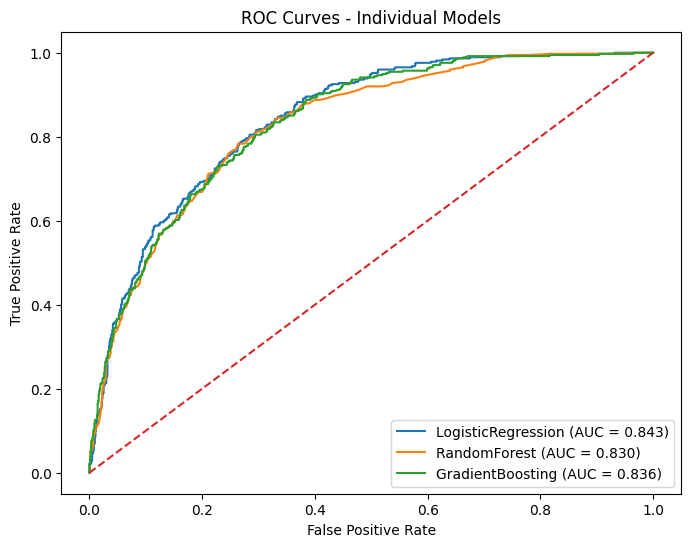

In [25]:
plt.figure(figsize=(8,6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test_p)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Individual Models")
plt.legend()
plt.show()

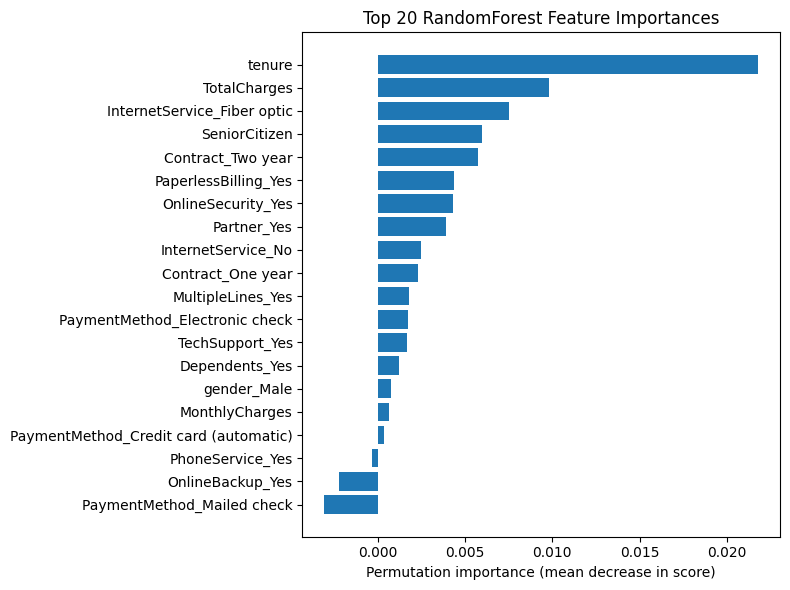

In [26]:
rf = models['RandomForest']
perm = permutation_importance(rf, X_test_p, y_test, n_repeats=20, random_state=42, n_jobs=-1)
imp_df = pd.DataFrame({
    'feature': numeric_features + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)),
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std
})
imp_df_sorted = imp_df.sort_values('importance_mean', ascending=False).head(20)
plt.figure(figsize=(8,6))
plt.barh(imp_df_sorted['feature'][::-1], imp_df_sorted['importance_mean'][::-1])
plt.xlabel("Permutation importance (mean decrease in score)")
plt.title("Top 20 RandomForest Feature Importances")
plt.tight_layout()
plt.show()

In [27]:
knn_clf = KNeighborsClassifier(n_neighbors=7)
svm_clf = SVC(probability=True, random_state=42)

In [28]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', models['LogisticRegression']),
        ('rf', models['RandomForest']),
        ('gb', models['GradientBoosting']),
        ('knn', knn_clf),
        ('svm', svm_clf)
    ],
    voting='soft'
)

In [29]:
voting_clf.fit(X_train_p, y_train)
y_pred_vote = voting_clf.predict(X_test_p)
y_prob_vote = voting_clf.predict_proba(X_test_p)[:, 1]

print("\n===== Voting Classifier Results =====")
print(classification_report(y_test, y_pred_vote, digits=4))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_vote))


===== Voting Classifier Results =====
              precision    recall  f1-score   support

           0     0.8360    0.9111    0.8719      1035
           1     0.6726    0.5053    0.5771       374

    accuracy                         0.8034      1409
   macro avg     0.7543    0.7082    0.7245      1409
weighted avg     0.7926    0.8034    0.7937      1409

ROC-AUC: 0.8390477666692501


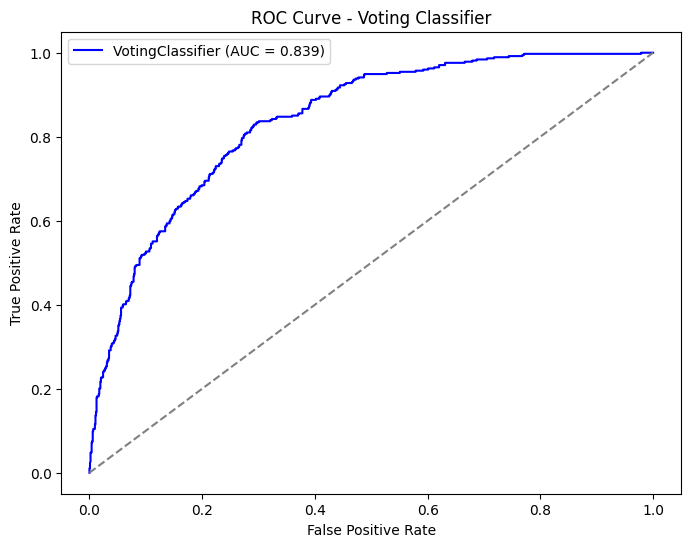

In [30]:
fpr, tpr, _ = roc_curve(y_test, y_prob_vote)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"VotingClassifier (AUC = {roc_auc:.3f})", color='blue')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Voting Classifier")
plt.legend()
plt.show()

In [31]:
def predict_new(df_new):
    df2 = df_new.copy()
    df2['TotalCharges'] = pd.to_numeric(df2['TotalCharges'], errors='coerce')
    for c in cols_replace_no_internet:
        if c in df2.columns:
            df2[c] = df2[c].replace({'No internet service':'No'})
    if 'MultipleLines' in df2.columns:
        df2['MultipleLines'] = df2['MultipleLines'].replace({'No phone service':'No'})
    missing_idx = df2['TotalCharges'].isna()
    if missing_idx.any():
        df2.loc[missing_idx, 'TotalCharges'] = df2.loc[missing_idx, 'MonthlyCharges'] * df2.loc[missing_idx, 'tenure']
    df2 = df2[numeric_features + categorical_features]
    Xp = preprocessor.transform(df2)
    return voting_clf.predict_proba(Xp)[:,1]

print("\nExample churn probabilities for 5 test customers:")
print(predict_new(X_test.head(5)))


Example churn probabilities for 5 test customers:
[0.04052972 0.80888781 0.06082212 0.30375113 0.03550184]
